In [2]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Path to files
ldlr_path = '/n/data2/hms/dbmi/sunyaev/lab/sgandhi/effect_size/variant_datasets/ldlr'

# Load datasets based on descriptions [cite: 1, 3, 5, 7, 9]
df_func = pd.read_csv(os.path.join(ldlr_path, 'science.ady7186_data_s1.csv')) # LDL Uptake
df_abun = pd.read_csv(os.path.join(ldlr_path, 'science.ady7186_data_s2.csv')) # Abundance
df_vldl = pd.read_csv(os.path.join(ldlr_path, 'science.ady7186_data_s3.csv')) # Uptake + VLDL
df_clin = pd.read_csv(os.path.join(ldlr_path, 'science.ady7186_data_s4.csv')) # ClinGen Labels
df_calib = pd.read_csv(os.path.join(ldlr_path, 'science.ady7186_data_s5.csv')) # Calibration

# 1. Merge the datasets
# 1. Merge the datasets (same as before)
df_merged = pd.merge(
    df_func, 
    df_abun, 
    on=['hgvs_pro', 'hgvsp', 'aapos'], 
    suffixes=('_func', '_abun')
)

# Exploratory data analysis

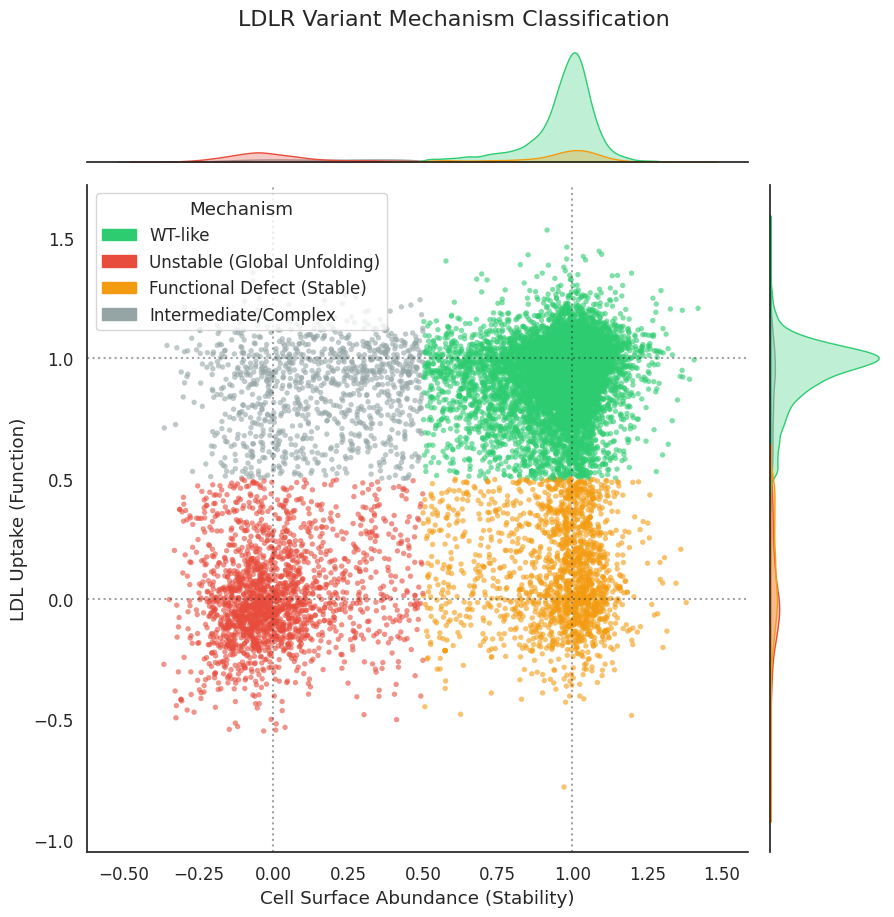

In [ ]:
import matplotlib.patches as mpatches

# 2. Define Thresholds to Classify Mechanism
# Based on the previous plot, ~0.5 seems to be the valley between WT and Loss
CUTOFF = 0.5

def classify_variant(row):
    if row['score_abun'] > CUTOFF and row['score_func'] > CUTOFF:
        return 'WT-like'
    elif row['score_abun'] < CUTOFF and row['score_func'] < CUTOFF:
        return 'Unstable (Global Unfolding)'
    elif row['score_abun'] > CUTOFF and row['score_func'] < CUTOFF:
        return 'Functional Defect (Stable)' # <--- Your specific interest
    else:
        return 'Intermediate/Complex'

df_merged['Mechanism'] = df_merged.apply(classify_variant, axis=1)

# 3. Setup Custom Color Palette
# Grey for boring, Red for Unstable, Gold/Orange for the "Interesting" Functional defects
palette = {
    'WT-like': '#2ecc71',                  # Green
    'Unstable (Global Unfolding)': '#e74c3c', # Red
    'Functional Defect (Stable)': '#f39c12',  # Orange/Gold (High contrast)
    'Intermediate/Complex': '#95a5a6'      # Grey
}

# 4. Create the JointGrid
sns.set_theme(style="white", font_scale=1.1)

g = sns.JointGrid(data=df_merged, x='score_abun', y='score_func', height=9)

# A. Central Plot: Scatter
sns.scatterplot(
    data=df_merged, x='score_abun', y='score_func', hue='Mechanism',
    palette=palette, ax=g.ax_joint, alpha=0.6, s=15, linewidth=0,
    legend=False  # We will build a custom legend
)

# B. Marginal Plots: KDE (Density)
# This shows the distribution of each score independently
sns.kdeplot(data=df_merged, x='score_abun', hue='Mechanism', palette=palette, 
            ax=g.ax_marg_x, fill=True, legend=False, alpha=0.3)
sns.kdeplot(data=df_merged, y='score_func', hue='Mechanism', palette=palette, 
            ax=g.ax_marg_y, fill=True, legend=False, alpha=0.3)

# 5. Add Reference Lines and Annotations
g.ax_joint.axvline(0, ls=':', c='k', alpha=0.4)
g.ax_joint.axhline(0, ls=':', c='k', alpha=0.4)
g.ax_joint.axvline(1, ls=':', c='k', alpha=0.4)
g.ax_joint.axhline(1, ls=':', c='k', alpha=0.4)

# Labels
g.set_axis_labels("Cell Surface Abundance (Stability)", "LDL Uptake (Function)")
g.fig.suptitle("LDLR Variant Mechanism Classification", y=1.02, fontsize=16)

# Custom Legend to make it readable
handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
g.ax_joint.legend(handles=handles, loc='upper left', title="Mechanism", frameon=True)

plt.show()

In [25]:
pos_stats['score_func'].min()

-0.015826768333333335

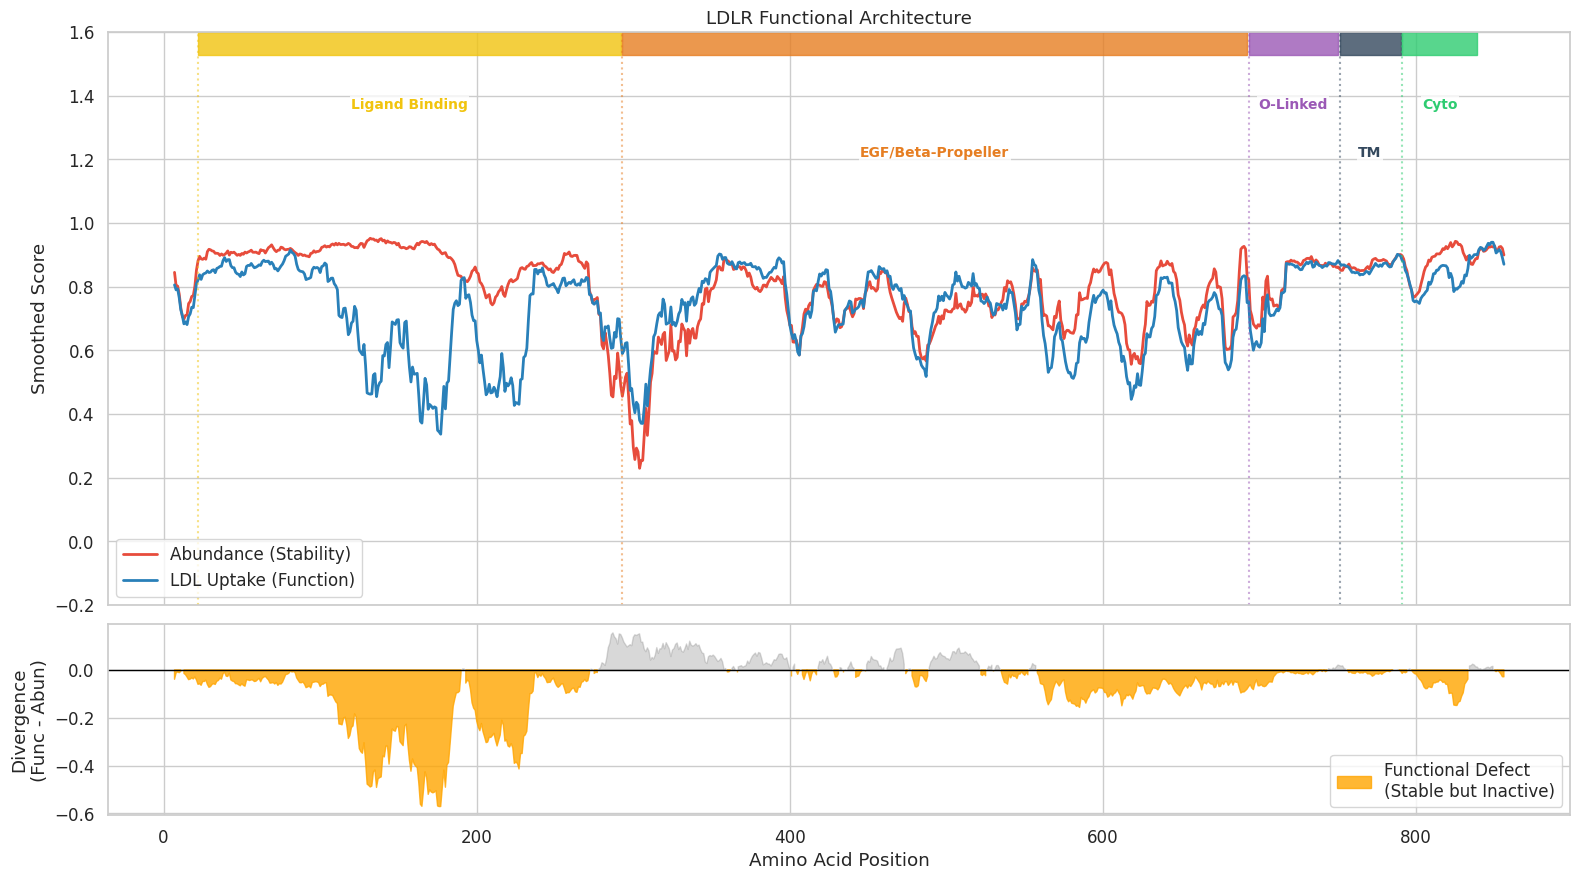

In [26]:
# 2. Calculate Mean Scores per Position
# We group by residue position to see domain-level effects
pos_stats = df_merged.groupby('aapos')[['score_func', 'score_abun']].mean().reset_index()

WINDOW = 10
pos_stats['smooth_func'] = pos_stats['score_func'].rolling(window=WINDOW, center=True).mean()
pos_stats['smooth_abun'] = pos_stats['score_abun'].rolling(window=WINDOW, center=True).mean()
pos_stats['smooth_div'] = pos_stats['smooth_func'] - pos_stats['smooth_abun']

# --- 2. Define Domains with Staggered Heights ---
# (Start, End, Name, Color, Label_Height)
domains = [
    (22, 292, 'Ligand Binding', '#f1c40f', 1.35),       # High
    (293, 692, 'EGF/Beta-Propeller', '#e67e22', 1.2),   # Low
    (693, 750, 'O-Linked', '#9b59b6', 1.35),            # High
    (751, 790, 'TM', '#34495e', 1.2),                   # Low
    (791, 839, 'Cyto', '#2ecc71', 1.35)                 # High
]

# --- 3. Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# === TOP PANEL: Scores & Domains ===
# Plot the data lines
sns.lineplot(data=pos_stats, x='aapos', y='smooth_abun', label='Abundance (Stability)', 
             color='#e74c3c', lw=2, ax=ax1)
sns.lineplot(data=pos_stats, x='aapos', y='smooth_func', label='LDL Uptake (Function)', 
             color='#2980b9', lw=2, ax=ax1)

# Add Domain Bars and Labels
for start, end, name, color, height in domains:
    # A. Colored bar at the very top (like a gene track)
    ax1.axvspan(start, end, ymin=0.96, ymax=1.0, color=color, alpha=0.8)
    
    # B. Vertical divider lines
    ax1.axvline(start, color=color, linestyle=':', alpha=0.5)
    
    # C. Staggered Text Labels (Centered in the domain)
    midpoint = (start + end) / 2
    ax1.text(midpoint, height, name, ha='center', va='bottom', 
             fontsize=10, fontweight='bold', color=color, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

ax1.set_ylabel("Smoothed Score")
ax1.set_title("LDLR Functional Architecture")
ax1.legend(loc="lower left", frameon=True)
ax1.set_ylim(-0.2, 1.6) # Give space at top for labels

# === BOTTOM PANEL: Divergence ===
# Fill the "Functional Gap"
ax2.fill_between(pos_stats['aapos'], pos_stats['smooth_div'], 0, 
                 where=(pos_stats['smooth_div'] < 0), 
                 color='orange', alpha=0.8, label='Functional Defect\n(Stable but Inactive)')

# Fill the "Instability Gap" (optional, where stability is worse than function - usually noise)
ax2.fill_between(pos_stats['aapos'], pos_stats['smooth_div'], 0, 
                 where=(pos_stats['smooth_div'] > 0), 
                 color='grey', alpha=0.3)

ax2.axhline(0, color='black', lw=1)
ax2.set_ylabel("Divergence\n(Func - Abun)")
ax2.set_xlabel("Amino Acid Position")
ax2.legend(loc="lower right")

# Final Cleanup
plt.tight_layout()
plt.subplots_adjust(hspace=0.05) # Squeeze panels together
plt.show()

Plotting 167 variants.


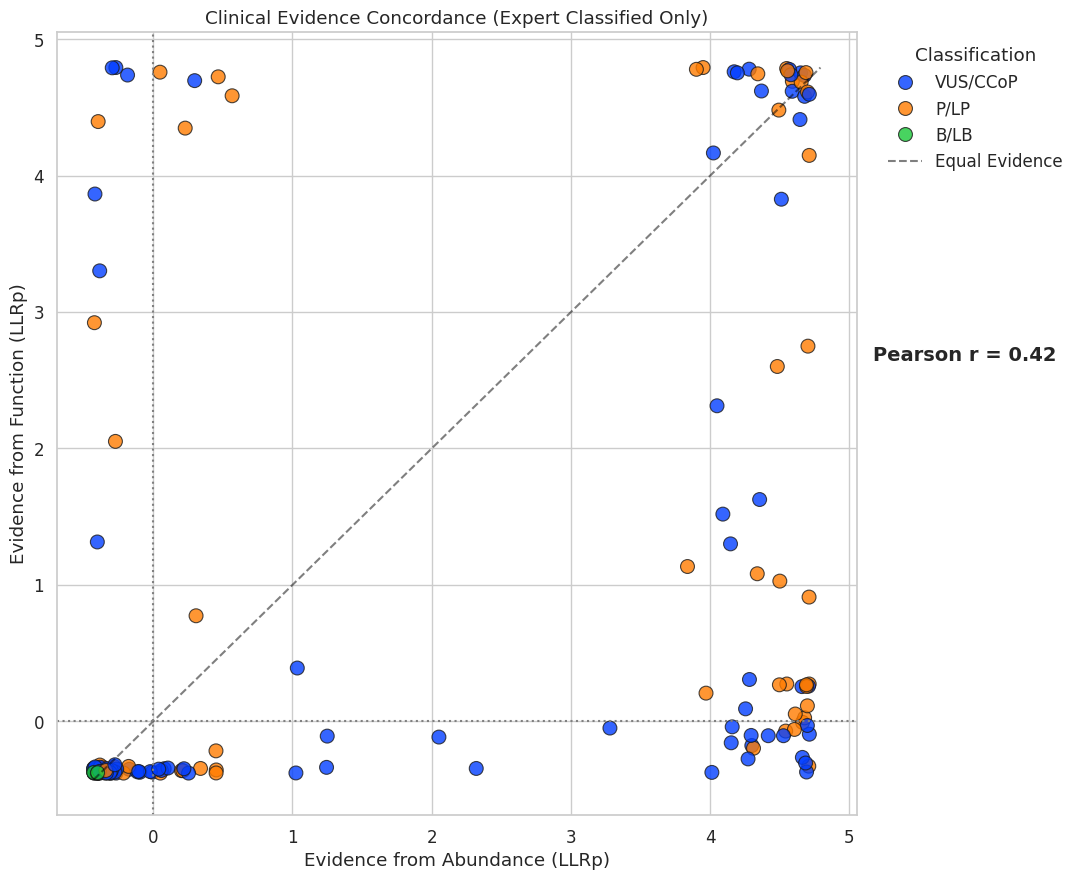

In [35]:
from scipy.stats import pearsonr

# 2. CLEAN DATA
# A. Filter out rows where VCEP is missing (removes "Unclassified" from legend)
df_clean = df_calib.dropna(subset=['VCEP'])

# B. Filter out rows where Scores are NaN or Infinite (prevents Pearson Error)
cols = ['LLRp (abundance)', 'LLRp (function)']
df_clean = df_clean.dropna(subset=cols)
mask_finite = np.isfinite(df_clean[cols]).all(axis=1)
df_clean = df_clean[mask_finite]

print(f"Plotting {len(df_clean)} variants.")

# 3. Calculate Correlation
r, p_val = pearsonr(df_clean['LLRp (abundance)'], df_clean['LLRp (function)'])

# 4. Generate Plot
plt.figure(figsize=(11, 9)) # Slightly wider to accommodate legend on the side
sns.set_theme(style="whitegrid", font_scale=1.1)

# Main Scatter - REMOVED 'style' argument
ax = sns.scatterplot(
    data=df_clean,
    x='LLRp (abundance)',
    y='LLRp (function)',
    hue='VCEP',                
    s=100,                     
    alpha=0.8,
    edgecolor='k',
    palette='bright'
)

# 5. Add Reference Lines
limit_min = min(df_clean['LLRp (abundance)'].min(), df_clean['LLRp (function)'].min())
limit_max = max(df_clean['LLRp (abundance)'].max(), df_clean['LLRp (function)'].max())
plt.plot([limit_min, limit_max], [limit_min, limit_max], ls='--', c='black', alpha=0.5, label='Equal Evidence')

plt.axvline(0, ls=':', c='grey')
plt.axhline(0, ls=':', c='grey')

# 6. Adjust Legend and Add Text
# Place Legend outside top-right
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Classification", frameon=False)

# Place Correlation Text BELOW the legend
# x=1.02 (same alignment as legend), y=0.6 (approx halfway down the side)
plt.text(
    1.02, 0.6, 
    f'Pearson r = {r:.2f}', 
    transform=ax.transAxes, 
    fontsize=14, 
    fontweight='bold',
    verticalalignment='top'
)

plt.title("Clinical Evidence Concordance (Expert Classified Only)")
plt.xlabel("Evidence from Abundance (LLRp)")
plt.ylabel("Evidence from Function (LLRp)")

plt.tight_layout()
plt.show()

# Simulation

In [11]:
from wf_sim_tools.api import run_sims

# Generate Pairs within 100bp (~33 Amino Acids)
MAX_DIST_AA = 33
pairs_list = []

print(f"Generating proximal pairs (Dist <= {MAX_DIST_AA} AA)...")
for lag in range(1, MAX_DIST_AA + 1):
    df_B = df_merged[['aapos', 'score_func', 'score_abun']].copy()
    df_B['join_key'] = df_B['aapos'] - lag
    merged_lag = pd.merge(df_merged, df_B, left_on='aapos', right_on='join_key', suffixes=('_A', '_B'))
    pairs_list.append(merged_lag)

df_all_pairs = pd.concat(pairs_list, ignore_index=True)
print(f"Total available pairs: {len(df_all_pairs)}")

# Sample specific pairs for simulation
N_PAIRS_TO_SIMULATE = 10  # Number of pairs to sample (start small for testing)

simulation_cohort = df_all_pairs.sample(n=min(N_PAIRS_TO_SIMULATE, len(df_all_pairs))).copy()

Generating proximal pairs (Dist <= 33 AA)...
Total available pairs: 10120115


In [12]:
from tqdm import tqdm

results = []
SCALING_FACTOR = 0.05
N_REPLICATES = 1000
POP_SIZE = 20000
THETA=0.1
RHO=0

print(f"Starting simulations for {len(simulation_cohort)} pairs...")

for idx, row in tqdm(simulation_cohort.iterrows()):
    # Transform Score to Beta (Selection Coefficient)
    # Center on 1.0 (WT) and scale down
    # Note: We focus on Phenotype 1 (Function) for this specific correlation question,
    # but you could run this loop for Abundance too.
    b1 = (row['score_func_A'] - 1.0) * SCALING_FACTOR
    b2 = (row['score_func_B'] - 1.0) * SCALING_FACTOR
    
    # Run the Simulator
    sim_output = run_sims(
        n_sims=N_REPLICATES,
        pop_size=POP_SIZE,
        theta=THETA,
        beta1=b1,
        beta2=b2,
        rho=RHO, 
        symmetry=1,
        polygenic=False
    )
    
    # Analyze Output
    # We define fixation as the double mutant (N11) reaching > 95% frequency
    # Assuming sim_output has columns like N00, N01, N10, N11
    # Check if 'N11' exists, otherwise adapt to your tool's specific output col names
    if 'N11' in sim_output.columns:
        n_fixed = sim_output[sim_output['N11'] >= (0.95 * POP_SIZE)].shape[0]
    else:
        n_fixed = 0 # Fallback
        
    fixation_rate = n_fixed / N_REPLICATES
    
    results.append({
        'pair_id': idx,
        'score_A': row['score_func_A'],
        'score_B': row['score_func_B'],
        'beta_A': b1,
        'beta_B': b2,
        'fixation_rate': fixation_rate,
        'is_viable': fixation_rate > 0  # Did it ever fix?
    })

df_results = pd.DataFrame(results)

Starting simulations for 10 pairs...


0it [00:00, ?it/s]

10it [01:13,  7.31s/it]


In [ ]:
# Generate 100,000 variant pairs within 35 AA for large-scale simulations
MAX_DIST_AA = 35
N_PAIRS_TO_SAMPLE = 100000
SCALING_FACTOR = 0.05

print(f"Generating all proximal pairs (Dist <= {MAX_DIST_AA} AA)...")
pairs_list = []

for lag in range(1, MAX_DIST_AA + 1):
    df_B = df_merged[['aapos', 'score_func', 'score_abun']].copy()
    df_B['join_key'] = df_B['aapos'] - lag
    merged_lag = pd.merge(df_merged, df_B, left_on='aapos', right_on='join_key', suffixes=('_A', '_B'))
    pairs_list.append(merged_lag)

df_all_pairs = pd.concat(pairs_list, ignore_index=True)
print(f"Total available pairs: {len(df_all_pairs):,}")

# Sample 100k pairs
print(f"Sampling {N_PAIRS_TO_SAMPLE:,} pairs for simulation...")
simulation_pairs = df_all_pairs.sample(n=min(N_PAIRS_TO_SAMPLE, len(df_all_pairs)), random_state=42).copy()

# Calculate beta values for both phenotypes
simulation_pairs['beta_func_A'] = (simulation_pairs['score_func_A'] - 1.0) * SCALING_FACTOR
simulation_pairs['beta_func_B'] = (simulation_pairs['score_func_B'] - 1.0) * SCALING_FACTOR
simulation_pairs['beta_abun_A'] = (simulation_pairs['score_abun_A'] - 1.0) * SCALING_FACTOR
simulation_pairs['beta_abun_B'] = (simulation_pairs['score_abun_B'] - 1.0) * SCALING_FACTOR

# Add pair ID and distance
simulation_pairs['pair_id'] = range(len(simulation_pairs))
simulation_pairs['distance'] = simulation_pairs['aapos_B'] - simulation_pairs['aapos_A']

# Select columns to save
cols_to_save = ['pair_id', 'aapos_A', 'aapos_B', 'distance',
                'score_func_A', 'score_func_B', 'score_abun_A', 'score_abun_B',
                'beta_func_A', 'beta_func_B', 'beta_abun_A', 'beta_abun_B']

# Create output directory if needed
os.makedirs('dataframes', exist_ok=True)

# Save to CSV
output_file = 'dataframes/variant_pairs_100k.csv'
simulation_pairs[cols_to_save].to_csv(output_file, index=False)
print(f"\nSaved {len(simulation_pairs):,} pairs to {output_file}")
print(f"Distance range: {simulation_pairs['distance'].min()}-{simulation_pairs['distance'].max()} AA")
print(f"\nFirst few rows:")
print(simulation_pairs[cols_to_save].head())

Generating all proximal pairs (Dist <= 35 AA)...
Total available pairs: 10,719,242
Sampling 100,000 pairs for simulation...

Saved 100,000 pairs to dataframes/variant_pairs_100k.csv
Distance range: 1-35 AA

First few rows:
          pair_id  aapos_A  aapos_B  distance  score_func_A  score_func_B  \
10039871        0      612      645        33     -0.009309      0.927308   
385881          1      167      169         2     -0.116021      0.996428   
568929          2      713      715         2      0.989951      0.994834   
5347489         3      179      197        18      0.078254     -0.316497   
1748764         4      504      510         6     -0.137261      0.281854   

          score_abun_A  score_abun_B  beta_func_A  beta_func_B  beta_abun_A  \
10039871      1.104662      0.986132    -0.050465    -0.003635     0.005233   
385881        1.081393      1.011681    -0.055801    -0.000179     0.004070   
568929        1.036202      1.011379    -0.000502    -0.000258     0.001810  

# Pleiotropy

In [3]:
position_correlations = df_merged.groupby('aapos').apply(
    lambda x: x['score_func'].corr(x['score_abun'])
).reset_index(name='pleiotropy_corr')

print("--- Local Pleiotropy (Per-Position Correlation) ---")
print(position_correlations.head())

--- Local Pleiotropy (Per-Position Correlation) ---
   aapos  pleiotropy_corr
0      2         0.504845
1      3         0.845096
2      4         0.598992
3      5         0.821727
4      6         0.886304


/tmp/ipykernel_4156845/936125037.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  position_correlations = df_merged.groupby('aapos').apply(


In [6]:
# --- 3. Generate Proximal Pairs (Within 35 Residues) ---
# To do this efficiently without creating a massive N^2 matrix, we iterate by position lag.

MAX_DIST = 35
lags = range(1, MAX_DIST + 1)

spatial_data = []

# We create a dictionary of scores by position for fast lookup
# Key: Position, Value: Series of scores at that position
pos_groups_func = df_merged.groupby('aapos')['score_func']
pos_groups_abun = df_merged.groupby('aapos')['score_abun']

# Calculate correlations for each Lag (1 to 35)
for lag in lags:
    # We define neighbor pairs: (Pos i) vs (Pos i + lag)
    # We align the data by shifting
    
    # Get common positions that have a neighbor at +lag
    positions = df_merged['aapos'].unique()
    valid_starts = [p for p in positions if (p + lag) in positions]
    
    # Collect all scores for these pairs
    # Note: We are correlating the *population* of variants at i with *population* at i+lag
    # Standard approach: Correlate the Mean Scores to see architectural structure
    # Alternative: Correlate every variant with every variant (Computationally heavy and noisy)
    
    # Using MEANS for robust structural correlation (Standard for "Effect Size Correlation structure")
    means_func = df_merged.groupby('aapos')['score_func'].mean()
    means_abun = df_merged.groupby('aapos')['score_abun'].mean()
    
    # Align vectors
    vec_a_func = means_func.loc[valid_starts].values
    vec_b_func = means_func.loc[[p + lag for p in valid_starts]].values
    
    vec_a_abun = means_abun.loc[valid_starts].values
    vec_b_abun = means_abun.loc[[p + lag for p in valid_starts]].values
    
    # Calculate Correlations
    # Request 1: Effect size correlation for each phenotype
    corr_func = np.corrcoef(vec_a_func, vec_b_func)[0, 1]
    corr_abun = np.corrcoef(vec_a_abun, vec_b_abun)[0, 1]
    
    # Request 2: Effect size correlation BETWEEN phenotypes (Cross-Correlation)
    # Does Stability at A predict Function at B?
    corr_cross = np.corrcoef(vec_a_abun, vec_b_func)[0, 1]
    
    spatial_data.append({
        'Distance': lag,
        'Corr_Func': corr_func,
        'Corr_Abun': corr_abun,
        'Corr_Cross_Pheno': corr_cross
    })

df_spatial = pd.DataFrame(spatial_data)

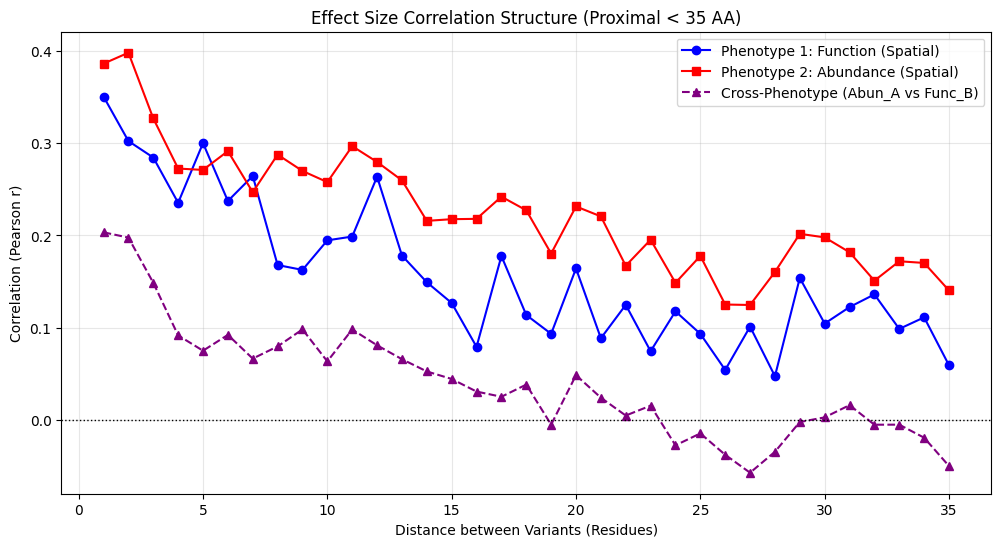

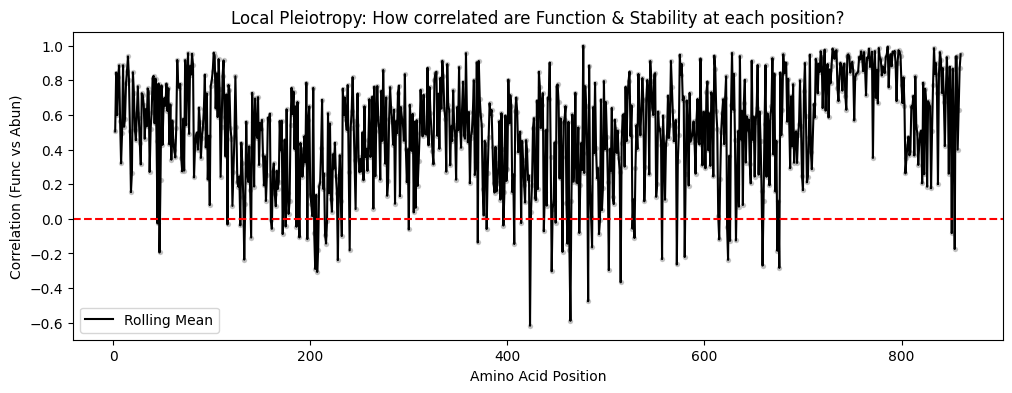

In [8]:
# --- 4. Visualization ---

# Plot A: The Correlation Structure (Requests 1 & 2)
plt.figure(figsize=(12, 6))
plt.plot(df_spatial['Distance'], df_spatial['Corr_Func'], marker='o', label='Phenotype 1: Function (Spatial)', color='blue')
plt.plot(df_spatial['Distance'], df_spatial['Corr_Abun'], marker='s', label='Phenotype 2: Abundance (Spatial)', color='red')
plt.plot(df_spatial['Distance'], df_spatial['Corr_Cross_Pheno'], marker='^', label='Cross-Phenotype (Abun_A vs Func_B)', color='purple', linestyle='--')

plt.axhline(0, color='black', linewidth=1, linestyle=':')
plt.xlabel("Distance between Variants (Residues)")
plt.ylabel("Correlation (Pearson r)")
plt.title(f"Effect Size Correlation Structure (Proximal < {MAX_DIST} AA)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot B: The Per-Variant/Position Correlation (Request 3)
plt.figure(figsize=(12, 4))
sns.scatterplot(data=position_correlations, x='aapos', y='pleiotropy_corr', alpha=0.5, s=15, color='grey')
# Add a smoothed trend line
sns.lineplot(data=position_correlations, x='aapos', y='pleiotropy_corr', color='black', label='Rolling Mean', errorbar=None)

plt.axhline(0, ls='--', c='red', label='Uncoupled')
plt.title("Local Pleiotropy: How correlated are Function & Stability at each position?")
plt.xlabel("Amino Acid Position")
plt.ylabel("Correlation (Func vs Abun)")
plt.show()

In [12]:
# 2. Generate Pairs within 35 Residues (The "Proximal Bin")
# We iterate through lags 1 to 35 to efficiently build the pairs dataframe
proximal_pairs_list = []
MAX_DIST = 35

print(f"Generating pairs for bin size: {MAX_DIST} residues...")

for lag in range(1, MAX_DIST + 1):
    # Create a copy for the "Neighbor" (B)
    df_B = df_merged[['aapos', 'score_func', 'score_abun']].copy()
    
    # Shift position of B so it aligns with A
    # If A is at 10 and lag is 5, we want to grab B at 15.
    # So we pretend B is at 15-5 = 10 to match with A.
    df_B['join_key'] = df_B['aapos'] - lag
    
    # Merge A (at pos) with B (at pos + lag)
    merged_lag = pd.merge(
        df_merged, 
        df_B, 
        left_on='aapos', 
        right_on='join_key', 
        suffixes=('_A', '_B')
    )
    
    proximal_pairs_list.append(merged_lag)

# Concatenate all lags into one massive "Proximal Pairs" dataframe
df_pairs = pd.concat(proximal_pairs_list, ignore_index=True)

print(f"Total Proximal Pairs Generated: {len(df_pairs):,}")

# 3. Calculate Correlations for this Bin

# A. Effect Size Correlation: Phenotype 1 (Function)
r_func_pairs = df_pairs['score_func_A'].corr(df_pairs['score_func_B'])

# B. Effect Size Correlation: Phenotype 2 (Abundance)
r_abun_pairs = df_pairs['score_abun_A'].corr(df_pairs['score_abun_B'])

# C. Effect Size Correlation: Between Phenotypes (Cross-Correlation)
# (Does Abundance of A predict Function of B?)
r_cross_pairs = df_pairs['score_abun_A'].corr(df_pairs['score_func_B'])

# D. For each individual variant: Correlation across phenotypes (Self-Correlation)
# This is the correlation of the two columns in the original dataset
r_self = df_merged['score_func'].corr(df_merged['score_abun'])

# 4. Output the Results
print("\n--- Correlation Results for Proximal Bin (<= 35 AA) ---")
print(f"1. Phenotype 1 (Function) Pairwise Correlation:   r = {r_func_pairs:.3f}")
print(f"2. Phenotype 2 (Abundance) Pairwise Correlation:  r = {r_abun_pairs:.3f}")
print(f"3. Cross-Phenotype Pairwise Correlation (A vs B): r = {r_cross_pairs:.3f}")
print(f"4. Self-Correlation (Function vs Abundance):      r = {r_self:.3f}")

Generating pairs for bin size: 35 residues...
Total Proximal Pairs Generated: 10,719,242

--- Correlation Results for Proximal Bin (<= 35 AA) ---
1. Phenotype 1 (Function) Pairwise Correlation:   r = 0.052
2. Phenotype 2 (Abundance) Pairwise Correlation:  r = 0.068
3. Cross-Phenotype Pairwise Correlation (A vs B): r = 0.011
4. Self-Correlation (Function vs Abundance):      r = 0.521


In [16]:
# 2. Define Helper Function to Generate Pairs and Calculate Correlations
def analyze_bin(df, min_dist, max_dist, label):
    print(f"\nGenerating pairs for {label} (Dist: {min_dist}-{max_dist} residues)...")
    pairs_list = []
    
    for lag in range(min_dist, max_dist + 1):
        # Create shifted copy for Neighbor B
        df_B = df[['aapos', 'score_func', 'score_abun']].copy()
        df_B['join_key'] = df_B['aapos'] - lag
        
        # Merge A with B
        merged_lag = pd.merge(
            df, 
            df_B, 
            left_on='aapos', 
            right_on='join_key', 
            suffixes=('_A', '_B')
        )
        pairs_list.append(merged_lag)
    
    if not pairs_list:
        return None
        
    df_pairs = pd.concat(pairs_list, ignore_index=True)
    
    # Calculate Correlations
    r_func = df_pairs['score_func_A'].corr(df_pairs['score_func_B'])
    r_abun = df_pairs['score_abun_A'].corr(df_pairs['score_abun_B'])
    r_cross = df_pairs['score_abun_A'].corr(df_pairs['score_func_B'])
    
    print(f"  - Pairs Generated: {len(df_pairs):,}")
    return r_func, r_abun, r_cross

# 3. Run Analysis for Both Bins
# Bin 1: Contact (1 to 5)
res_contact = analyze_bin(df_merged, 1, 5, "CONTACT BIN")

# Bin 2: Proximal (6 to 35)
res_proximal = analyze_bin(df_merged, 6, 35, "PROXIMAL BIN")

# 4. Self-Correlation (Baseline)
# This is intrinsic to the variant itself, so it's independent of neighbors
r_self = df_merged['score_func'].corr(df_merged['score_abun'])

# 5. Display Comparison
print("\n" + "="*60)
print(f"{'METRIC':<40} | {'CONTACT (1-5)':<15} | {'PROXIMAL (6-35)':<15}")
print("-" * 75)
print(f"{'Phenotype 1 (Function) Pairwise r':<40} | {res_contact[0]:.3f}           | {res_proximal[0]:.3f}")
print(f"{'Phenotype 2 (Abundance) Pairwise r':<40} | {res_contact[1]:.3f}           | {res_proximal[1]:.3f}")
print(f"{'Cross-Phenotype (Abun_A vs Func_B) r':<40} | {res_contact[2]:.3f}           | {res_proximal[2]:.3f}")
print("-" * 75)
print(f"{'Self-Correlation (Baseline)':<40} | {r_self:.3f}")
print("="*60)


Generating pairs for CONTACT BIN (Dist: 1-5 residues)...
  - Pairs Generated: 1,564,495

Generating pairs for PROXIMAL BIN (Dist: 6-35 residues)...
  - Pairs Generated: 9,154,747

METRIC                                   | CONTACT (1-5)   | PROXIMAL (6-35)
---------------------------------------------------------------------------
Phenotype 1 (Function) Pairwise r        | 0.093           | 0.046
Phenotype 2 (Abundance) Pairwise r       | 0.097           | 0.063
Cross-Phenotype (Abun_A vs Func_B) r     | 0.040           | 0.006
---------------------------------------------------------------------------
Self-Correlation (Baseline)              | 0.521


# Compensation

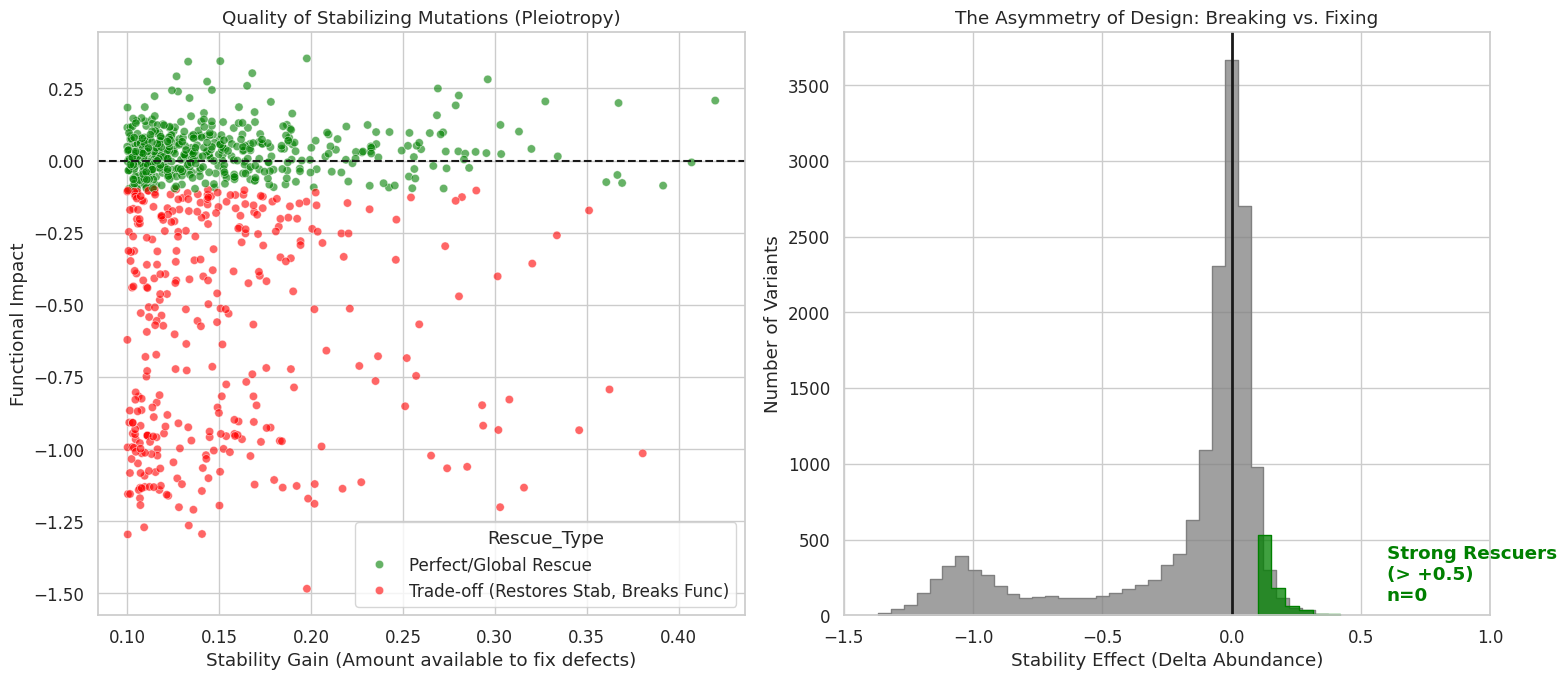

--- Rescue Statistics ---
Total Variants Scanned: 16330
Potential Stabilizers (> +0.1): 819
  - Trade-off (Bad Function): 336
  - Perfect (Good Function): 483


In [36]:
# 2. Calculate "Deltas" (Effect relative to WT)
# Assuming WT score is ~1.0 (based on previous plots)
df_merged['delta_func'] = df_merged['score_func'] - 1.0
df_merged['delta_abun'] = df_merged['score_abun'] - 1.0

# 3. Filter for "Stabilizers" (The potential rescuers)
# We only care about variants that ADD stability (delta_abun > 0)
stabilizers = df_merged[df_merged['delta_abun'] > 0.1].copy() # Cutoff 0.1 to ignore noise

# 4. Classify Stabilizers into Scenarios
def classify_rescuer(row):
    if row['delta_func'] < -0.1:
        return 'Trade-off (Restores Stab, Breaks Func)' # Scenario A
    elif row['delta_func'] > -0.1:
        return 'Perfect/Global Rescue'                   # Scenario B
    return 'Neutral'

stabilizers['Rescue_Type'] = stabilizers.apply(classify_rescuer, axis=1)

# --- VISUALIZATION 1: The Inventory of Rescuers ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: Scatter of Stabilizers (Pleiotropy Check)
sns.scatterplot(data=stabilizers, x='delta_abun', y='delta_func', 
                hue='Rescue_Type', palette={'Trade-off (Restores Stab, Breaks Func)': 'red', 'Perfect/Global Rescue': 'green'},
                alpha=0.6, ax=ax1)
ax1.axhline(0, ls='--', c='k')
ax1.set_title("Quality of Stabilizing Mutations (Pleiotropy)")
ax1.set_xlabel("Stability Gain (Amount available to fix defects)")
ax1.set_ylabel("Functional Impact")

# --- VISUALIZATION 2: "How many mutations?" (Histogram) ---
# We bin the library by Stability Effect to see the "Rescue Potential"
sns.histplot(df_merged['delta_abun'], binwidth=0.05, kde=False, ax=ax2, color='grey', element="step")

# Highlight the stabilizers
sns.histplot(stabilizers['delta_abun'], binwidth=0.05, kde=False, ax=ax2, color='green', element="step")

ax2.set_xlim(-1.5, 1.0) # Focus on the relevant range
ax2.axvline(0, c='k', lw=2, label='WT')
ax2.set_title("The Asymmetry of Design: Breaking vs. Fixing")
ax2.set_xlabel("Stability Effect (Delta Abundance)")
ax2.set_ylabel("Number of Variants")

# Add text to answer "How many mutations?"
n_super = len(df_merged[df_merged['delta_abun'] > 0.5])
ax2.text(0.6, 100, f"Strong Rescuers\n(> +0.5)\nn={n_super}", color='green', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Output Stats for the User
print("--- Rescue Statistics ---")
print(f"Total Variants Scanned: {len(df_merged)}")
print(f"Potential Stabilizers (> +0.1): {len(stabilizers)}")
print(f"  - Trade-off (Bad Function): {len(stabilizers[stabilizers['Rescue_Type'] == 'Trade-off (Restores Stab, Breaks Func)'])}")
print(f"  - Perfect (Good Function): {len(stabilizers[stabilizers['Rescue_Type'] == 'Perfect/Global Rescue'])}")